In [1]:
import os.path as osp
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from mymodelzoo import*
from transforms import*
from adversary import*

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [2]:
SEED = 888

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
ckp_out_root = './models/lenet'
# Load a checkpoint
ckp_dir = osp.join(ckp_out_root, "checkpoint.pth.tar")
if osp.isfile(ckp_dir):
    ckp = torch.load(ckp_dir)
    print(f"=> Loading checkpoint from {ckp_dir}")
    ckp_epoch = ckp["epoch"]
    best_test_acc = ckp["best_acc"]
    model.load_state_dict(ckp["state_dict"])
    model.eval()
    print(f"=> Loaded checkpoint '{ckp_dir}' (epoch {ckp_epoch})")
    print(f"=> Best test acc. {best_test_acc}%")
else:
    print(f"No checkpoint found in {ckp_dir}")

=> Loading checkpoint from ./models/lenet/checkpoint.pth.tar
=> Loaded checkpoint './models/lenet/checkpoint.pth.tar' (epoch 2)
=> Best test acc. 99.0%


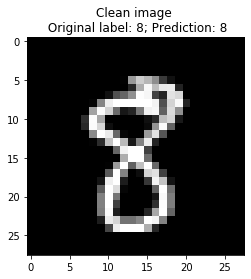

In [4]:
with open('./benign_8.np', 'rb') as file:
    benign = pickle.load(file)

with torch.no_grad():
    logits = model(benign.to(device))
logits = logits.cpu().numpy()

ori_label = 8
plt.imshow(benign[0][0].numpy(), cmap='gray')
plt.title(f"Clean image \n Original label: {ori_label}; Prediction: {np.argmax(logits)}")
plt.show()

In [5]:
T = [get_random_gaussian(max_sigma=0.1),
     get_random_rotate(min_deg=-22.5, max_deg=22.5),
     get_random_contrast(min_alpha=0.5, max_alpha=1.5),
     get_random_brightness(min_beta=-0.05, max_beta=0.05),
     get_random_blur(min_blur_size=1, max_blur_size=5)]

random_transform = RandomTransform(T)

In [30]:
# Experiment params
step_size = 1e-3
targeted = True
ori_label = 8
adv_label = 3 # Targeted label
steps = 5000
verbose = False
ori_img = benign.numpy()

# Evaluation params
eval_steps = 5000

candidate_eps = np.linspace(0.1, 0.3, 50)
succ_list, fail_list, other_list = [], [], []
for eps in candidate_eps:
    eps_below = ori_img - eps
    eps_above = ori_img + eps
    adv_img = ori_img.copy()

    # Crafting
    adv_img = eot_craft(model, T, random_transform, adv_img, adv_label, steps, step_size, targeted, eps_below, eps_above, device, verbose=verbose)

    # Evaluating
    succ_rate, fail_rate, other_rate = adv_eval(model, eval_steps, adv_img, ori_label, adv_label, targeted, random_transform, device, verbose=verbose)
    succ_list.append(succ_rate)
    fail_list.append(fail_rate)
    other_list.append(other_rate)

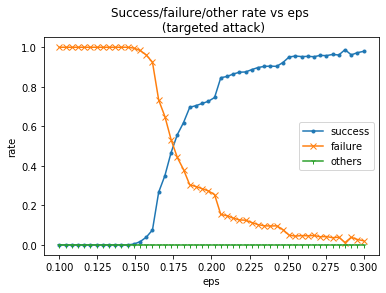

In [34]:
plt.plot(candidate_eps, succ_list, marker='.', label="success")
plt.plot(candidate_eps, fail_list, marker='x', label="failure")
plt.plot(candidate_eps, other_list, marker='1', label="others")
plt.title("Success/failure/other rate vs eps \n (targeted attack)")
plt.xlabel("eps")
plt.ylabel("rate")
plt.legend()
plt.show()

In [41]:
with open("./targeted_eps_succ.pkl", "wb") as file:
    pickle.dump((candidate_eps, succ_list), file)
with open("./targeted_eps_fail.pkl", "wb") as file:
    pickle.dump((candidate_eps, fail_list), file)
with open("./targeted_eps_other.pkl", "wb") as file:
    pickle.dump((candidate_eps, other_list), file)

In [46]:
candidate_eps[37], succ_list[37]

(0.2510204081632653, 0.9506)

In [48]:
# Experiment params
step_size = 1e-3
targeted = False
ori_label = 8
adv_label = 8 # Original label
steps = 5000
verbose = False
ori_img = benign.numpy()

# Evaluation params
eval_steps = 5000

candidate_eps = np.linspace(0.1, 0.3, 50)
succ_list, fail_list = [], []
for eps in candidate_eps:
    eps_below = ori_img - eps
    eps_above = ori_img + eps
    adv_img = ori_img.copy()

    # Crafting
    adv_img = eot_craft(model, T, random_transform, adv_img, adv_label, steps, step_size, targeted, eps_below, eps_above, device, verbose=verbose)

    # Evaluating
    succ_rate, fail_rate = adv_eval(model, eval_steps, adv_img, ori_label, adv_label, targeted, random_transform, device, verbose=verbose)
    succ_list.append(succ_rate)
    fail_list.append(fail_rate)
    other_list.append(other_rate)

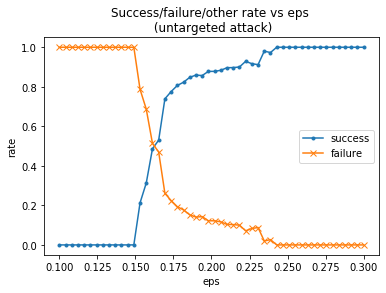

In [55]:
plt.plot(candidate_eps, succ_list, marker='.', label="success")
plt.plot(candidate_eps, fail_list, marker='x', label="failure")
plt.title("Success/failure/other rate vs eps \n (untargeted attack)")
plt.xlabel("eps")
plt.ylabel("rate")
plt.legend()
plt.show()

In [50]:
with open("./untargeted_eps_succ.pkl", "wb") as file:
    pickle.dump((candidate_eps, succ_list), file)
with open("./untargeted_eps_fail.pkl", "wb") as file:
    pickle.dump((candidate_eps, fail_list), file)

In [54]:
print(candidate_eps[34], succ_list[34])
print(candidate_eps[35], succ_list[35])

0.2387755102040816 0.9732
0.24285714285714285 1.0
